In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister


def lookup_qiskit_ordering(particle, spin) -> int:
    """
    Looks up the Qiskit mapping from a 2D lattice to a 1D qubit-line
    
    Parameters:
        particle (int): The index of the particle in the physical lattice.
        spin (int): 0 for spin up, 1 for spin down.
    
    Returns:
        int: The index in the 1D qubit-line.
    """
    if spin == '↑':
        spin = 0
    elif spin == '↓':
        spin = 1

    if spin not in (0, 1):
        raise ValueError("spin must be 0 or 1")
    
    return 2*particle + spin


def add_long_range_interaction(circ, i, j, outer_op, alpha):
    """
    Add a long range interaction that is decomposed into two-qubit gates.
    outer_op=X: X_i ⊗ Z_{i+1} ⊗ ... ⊗ Z_{j-1} ⊗ X_j
    outer_op=Y: Y_i ⊗ Z_{i+1} ⊗ ... ⊗ Y_{j-1} ⊗ X_j
    """
    import numpy as np
    
    if i >= j:
        raise Exception("Assumption i < j violated.")
    
    phi = 1*alpha
    # circ.rz(phi=phi, qubit=j)

    for k in range(i, j):
        # prepend the CNOT gate
        aux_circ = QuantumCircuit(circ.num_qubits)
        aux_circ.cx(control_qubit=k, target_qubit=j)
        circ.compose(aux_circ, front=True, inplace=True)
        # append the CNOT gate
        circ.cx(control_qubit=k, target_qubit=j)
    if outer_op == 'x' or outer_op == 'X':
        theta = np.pi/2
        # prepend the Ry gates
        aux_circ = QuantumCircuit(circ.num_qubits)
        aux_circ.ry(theta=theta, qubit=i)
        aux_circ.ry(theta=theta, qubit=j)
        circ.compose(aux_circ, front=True, inplace=True)
        # append the same Ry gates with negative phase
        circ.ry(theta=-theta, qubit=i)
        circ.ry(theta=-theta, qubit=j)
    elif outer_op == 'y' or outer_op == 'Y':
        theta = np.pi/2
        # prepend the Rx gates
        aux_circ = QuantumCircuit(circ.num_qubits)
        aux_circ.rx(theta=theta, qubit=i)
        aux_circ.rx(theta=theta, qubit=j)
        circ.compose(aux_circ, front=True, inplace=True)
        # # append the same Rx gates with negative phase
        circ.rx(theta=-theta, qubit=i)
        circ.rx(theta=-theta, qubit=j)
    else:
        raise Exception("Only Pauli X or Y matrices are supported as outer operator.")
    

def add_hopping_term(circ, i, j, alpha):
    """
    Adds a hopping operator of the form
    exp(-i*(X_i ⊗ Z_{i+1} ⊗ ... ⊗ Z_{j-1} ⊗ X_j + Y_i ⊗ Z_{i+1} ⊗ ... ⊗ Z_{j-1} ⊗ Y_j))
    to the circuit.
    """
    XX = QuantumCircuit(circ.num_qubits)
    YY = QuantumCircuit(circ.num_qubits)
    add_long_range_interaction(XX, i, j, 'X', alpha)
    add_long_range_interaction(YY, i, j, 'Y', alpha)
    circ.compose(XX, inplace=True)
    circ.compose(YY, inplace=True)


def create_2D_Fermi_Hubbard_circuit(model, dt, timesteps):
    'H = -1/2 mu (I-Z) + 1/4 u (I-Z) (I-Z) - 1/2 t (XX + YY)'

    assert model['name'] == '2D_Fermi_Hubbard'

    mu = model['mu']
    u = model['u']
    t = model['t']
    n = model['num_trotter_steps']
    L = model['Lx'] * model['Ly']
    N = 2*L

    circ = QuantumCircuit(N)

    def H_1():
        """Add the time evolution of the chemical potential term"""
        theta = -mu*dt/(2*n)
        for j in range(L):
            q_up = lookup_qiskit_ordering(j, '↑')
            q_down = lookup_qiskit_ordering(j, '↓')
            circ.p(theta=theta, qubit=q_up)
            circ.p(theta=theta, qubit=q_down)

    def H_2():
        """Add the time evolution of the onsite interaction term"""
        theta = -u*dt/(2*n)
        for j in range(L):
            q_up = lookup_qiskit_ordering(j, '↑')
            q_down = lookup_qiskit_ordering(j, '↓')
            circ.cp(theta=theta, control_qubit=q_up, target_qubit=q_down)

    def H_3():
        """Add the time evolution of the kinetic hopping term"""
        alpha = t*dt/n

        def horizontal_odd():
            for y in range(model['Ly']):
                for x in range(model['Lx']-1):
                    if x % 2 == 0:
                        p1 = y*model['Lx'] + x
                        p2 = p1 + 1
                        #print("particle (" + str(p1) + ", " + str(p2) + ")")
                        q1_up = lookup_qiskit_ordering(p1, '↑')
                        q2_up = lookup_qiskit_ordering(p2, '↑')
                        q1_down = lookup_qiskit_ordering(p1, '↓')
                        q2_down = lookup_qiskit_ordering(p2, '↓')
                        add_hopping_term(circ, q1_up, q2_up, alpha)
                        add_hopping_term(circ, q1_down, q2_down, alpha)
                        #print("qubit ↑ (" + str(q1_up) + ", " + str(q2_up) + ")")
                        #print("qubit ↓ (" + str(q1_down) + ", " + str(q2_down) + ")")
                        #print("--")

        def horizontal_even():
            for y in range(model['Ly']):
                for x in range(model['Lx']-1):
                    if x % 2 != 0:
                        p1 = y*model['Lx'] + x
                        p2 = p1 + 1
                        #print("particle (" + str(p1) + ", " + str(p2) + ")")
                        q1_up = lookup_qiskit_ordering(p1, '↑')
                        q2_up = lookup_qiskit_ordering(p2, '↑')
                        q1_down = lookup_qiskit_ordering(p1, '↓')
                        q2_down = lookup_qiskit_ordering(p2, '↓')
                        add_hopping_term(circ, q1_up, q2_up, alpha)
                        add_hopping_term(circ, q1_down, q2_down, alpha)
                        #print("qubit ↑ (" + str(q1_up) + ", " + str(q2_up) + ")")
                        #print("qubit ↓ (" + str(q1_down) + ", " + str(q2_down) + ")")
                        #print("--")

        def vertical_odd():
            for y in range(model['Ly']-1):
                if y % 2 == 0:
                    for x in range(model['Lx']):
                        p1 = y*model['Lx'] + x
                        p2 = p1 + model['Lx']
                        #print("particle (" + str(p1) + ", " + str(p2) + ")")
                        q1_up = lookup_qiskit_ordering(p1, '↑')
                        q2_up = lookup_qiskit_ordering(p2, '↑')
                        q1_down = lookup_qiskit_ordering(p1, '↓')
                        q2_down = lookup_qiskit_ordering(p2, '↓')
                        add_hopping_term(circ, q1_up, q2_up, alpha)
                        add_hopping_term(circ, q1_down, q2_down, alpha)
                        #print("qubit ↑ (" + str(q1_up) + ", " + str(q2_up) + ")")
                        #print("qubit ↓ (" + str(q1_down) + ", " + str(q2_down) + ")")
                        #print("--")  

        def vertical_even():
            for y in range(model['Ly']-1):
                if y % 2 != 0:
                    for x in range(model['Lx']):
                        p1 = y*model['Lx'] + x
                        p2 = p1 + model['Lx']
                        #print("particle (" + str(p1) + ", " + str(p2) + ")")
                        q1_up = lookup_qiskit_ordering(p1, '↑')
                        q2_up = lookup_qiskit_ordering(p2, '↑')
                        q1_down = lookup_qiskit_ordering(p1, '↓')
                        q2_down = lookup_qiskit_ordering(p2, '↓')
                        add_hopping_term(circ, q1_up, q2_up, alpha)
                        add_hopping_term(circ, q1_down, q2_down, alpha)
                        #print("qubit ↑ (" + str(q1_up) + ", " + str(q2_up) + ")")
                        #print("qubit ↓ (" + str(q1_down) + ", " + str(q2_down) + ")")
                        #print("--")
        
        #for _ in range(n):
        horizontal_odd()
        horizontal_even()
        vertical_odd()
        vertical_even()

    for _ in range(timesteps):
        for _ in range(n):
            H_1()
            H_2()
            H_3()
            H_2()
            H_1()
    
    return circ

In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

In [3]:
shots = 1024

# Ising circuit

In [4]:
#from mqt.yaqs.core.libraries.circuit_library import create_ising_circuit

#num_qubits = 8
#circuit = create_ising_circuit(L=num_qubits, J=1, g=0.5, dt=0.1, timesteps=10)
#circuit.measure_all()

# Fermi-Hubbard circuit

In [5]:


Lx, Ly = 2, 2   # 2x2 square lattice
L = Lx * Ly     # Total sites
t = 1         # Hopping amplitude
U = 0.1         # On-site interaction
mu = 0.1

# Example: 4-site Fermi-Hubbard model (8 qubits for spin-up and spin-down)
num_sites = Lx * Ly
num_qubits = 2 * num_sites  # Each site has 2 qubits (up and down)

model = {'name': '2D_Fermi_Hubbard', 'Lx': Lx, 'Ly': Ly, 'mu': mu, 'u': U, 't': t, 'num_trotter_steps': 1}
circuit = create_2D_Fermi_Hubbard_circuit(model, dt=0, timesteps=1)
circuit.measure_all()

# num_qubits = 4
# circuit = QuantumCircuit(num_qubits)
# circuit.h(0)
# circuit.cx(0, 2)
# circuit.cx(3, 0)
# circuit.measure_all()
# print(circuit)

# Qiskit

## Statevector simulation

In [6]:
# Run the circuit
circ = QuantumCircuit(num_qubits)
# circ.initialize("111")
circ.compose(circuit, inplace=True)

In [7]:
#circ.save_statevector()

#simulator = AerSimulator()
#result = simulator.run(circ).result()

#from qiskit.visualization import state_visualization
#from IPython.display import Latex

#result = simulator.run(circ).result()
#state = result.data(0)['statevector']

#prefix = "$$\\begin{align}"
#suffix = "\\end{align}$$"
#state_to_latex = state_visualization._state_to_latex_ket(state.data, max_size = 128)

#Latex(prefix + state_to_latex + suffix)

## Shots simulation

{'00000000': 1024}


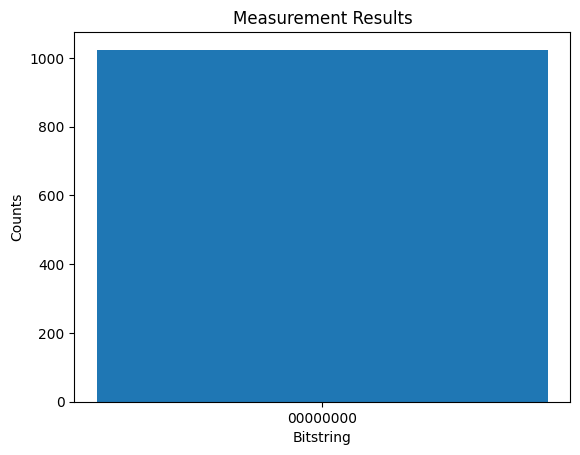

In [8]:
simulator = AerSimulator()
result = simulator.run(circ).result()
counts = result.get_counts(0)

print(counts)

import matplotlib.pyplot as plt

plt.bar(counts.keys(), counts.values())
plt.xlabel("Bitstring")
plt.ylabel("Counts")
plt.title("Measurement Results")
plt.show()

In [9]:
from mqt.yaqs.core.data_structures.networks import MPS

state = MPS(num_qubits, state="zeros")
# state.pad_bond_dimension(3)
for tensor in state.tensors:
    print(tensor.shape)

(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)


In [10]:
from mqt.yaqs.core.data_structures.simulation_parameters import WeakSimParams

max_bond_dim = 16
threshold = 1e-12
window_size = 0
sim_params = WeakSimParams(shots, max_bond_dim, threshold, window_size, get_state=True)

In [11]:
from mqt.yaqs import simulator

noise_model = None
simulator.run(state, circuit, sim_params, noise_model)
print(sim_params.output_state.to_vec())

2TDVP
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
2TDVP
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
2TDVP
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 2)
(2, 2, 2)
(2, 2, 1)
(2, 1, 1)
2TDVP
(2, 1, 2)
(2, 2, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 2)
(2, 2, 2)
(2, 2, 1)
(2, 1, 1)
2TDVP
(2, 1, 2)
(2, 2, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 2)
(2, 2, 2)
(2, 2, 1)
(2, 1, 1)
2TDVP
(2, 1, 2)
(2, 2, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 2)
(2, 2, 2)
(2, 2, 1)
(2, 1, 1)
2TDVP
(2, 1, 2)
(2, 2, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 1)
2TDVP
(2, 1, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 1)
2TDVP
(2, 1, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 1)
2TDVP
(2, 1, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 1)
2TDVP
(2, 1, 2)
(2, 2, 1)
(2, 1, 1)
(2, 1, 1)
(2, 1, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 1)
2TDVP
(2, 1, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 1)
(2, 1, 2

Measuring shots: 100%|█████████████████████| 1024/1024 [00:02<00:00, 494.64it/s]

[ 1.00000000e+000-5.64546856e-016j -4.90405483e-016+1.67155782e-016j
 -5.77123019e-018-2.25367332e-016j  5.29462079e-032+1.08465583e-031j
  7.85046229e-017-1.66533454e-016j -1.06620678e-032+9.47914205e-032j
 -5.03380214e-032+1.14126808e-032j  1.65216359e-047-1.61634882e-047j
 -2.35513869e-016-1.66533454e-016j  1.43334322e-031+4.23014139e-032j
 -3.61719955e-032+5.40382353e-032j  5.59358184e-048-3.43624639e-047j
 -4.62223187e-032+2.61472920e-032j  1.82970075e-047-2.05491032e-047j
  1.37558953e-047+5.69511996e-048j -6.58283591e-063+1.05532056e-063j
  4.94376913e-017-9.14494619e-016j  1.28618548e-031+4.56736972e-031j
 -2.06382529e-031-5.86388165e-033j  1.01808730e-046-4.30567343e-047j
 -1.48412860e-031-8.00250847e-032j  8.61591360e-047+1.44366727e-047j
  7.94823957e-048+4.65980663e-047j -1.39646315e-062-1.59080327e-062j
 -1.63937209e-031+2.07143136e-031j  4.57705334e-047-1.28987182e-046j
  4.76294154e-047+3.57506208e-047j -3.11477546e-062-6.81410138e-063j
  2.16264331e-047+4.35627234e-047j

In [12]:
print(sim_params.results)

{0: 1024}


In [13]:
def int_to_binary(n):
    """Convert an integer to its binary representation as a string."""
    if not isinstance(n, int):
        raise ValueError("Input must be an integer")
    return bin(n)[2:]  # Remove the '0b' prefix

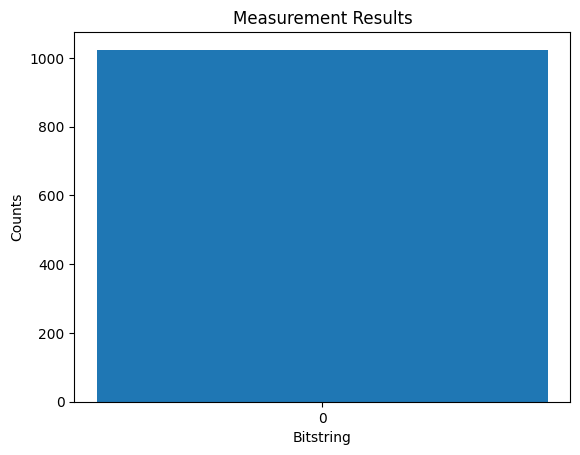

In [14]:
counts = {int_to_binary(k) : v for k, v in sim_params.results.items() if isinstance(k, int)}
plt.bar(counts.keys(), counts.values())
plt.xlabel("Bitstring")
plt.ylabel("Counts")
plt.title("Measurement Results")
plt.show()